In [ ]:
!git clone https://github.com/LiamMaclean216/Pytorch-Transfomer.git

Cloning into 'Pytorch-Transfomer'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 37 (delta 9), reused 34 (delta 8), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [ ]:
!python3  Transformer.ipynb

python3: can't open file 'Transformer.ipynb': [Errno 2] No such file or directory


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:

def a_norm(Q, K):
    m = torch.matmul(Q, K.transpose(2,1).float())
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float())
    
    return torch.softmax(m , -1) ### shape after  this is [15,6,6]

def attention(Q, K, V):
    #Attention(Q, K, V) = norm(QK)V
    a = a_norm(Q, K) #(batch_size, dim_attn, seq_length)
    print(f"a_norm {a.shape}")
    print(f"attention +{torch.matmul(a,  V).shape}")
    
    return  torch.matmul(a,  V) #(batch_size, seq_length, seq_length) ##shape is[15,6,10]

class AttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn):
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, dim_val)
        self.key = Key(dim_val, dim_attn)
        self.query = Query(dim_val, dim_attn)
    
    def forward(self, x, kv = None):
        if(kv is None):
            #Attention with x connected to Q,K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        
        #Attention with x as Q, external vector kv as K an V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.heads = nn.ModuleList(self.heads)
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
        
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
        #print(f"shape before Multihead {a.shape}")
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        print(f"shape after Multihead+{a.shape}")
        x = self.fc(a)
        print(f"shape after  linear layer in Multihead+{x.shape}")
        
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.dim_val = dim_val
        
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False)
        #self.fc2 = nn.Linear(5, dim_val)
    
    def forward(self, x):
        x = self.fc1(x)
        print(f"Value-+{x.shape}")
        #x = self.fc2(x)
        
        return x

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.dim_attn = dim_attn
        
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
        #self.fc2 = nn.Linear(5, dim_attn)
    
    def forward(self, x):
        x = self.fc1(x)
        print(f"Key-{x.shape}")
        #x = self.fc2(x)
        
        return x

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.dim_attn = dim_attn
        
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
        #self.fc2 = nn.Linear(5, dim_attn)
    
    def forward(self, x):
        print(f"beforeQuery-{x.shape}")
        x = self.fc1(x)
        print(f"Query-{x.shape}")
        #print(x.shape)
        #x = self.fc2(x)
        
        return x

# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)                            ####  PE(pos,2i)=sin(pos100002i/dmodel), PE(pos,2i+1)=cos(pos100002i/dmodel) which is according to widely used formula similar thing we are doing here
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)                  ####doubt- what is this???

    def forward(self, x):
        x = x + self.pe[:x.size(1), :]. squeeze(1)
        return x     
    
def get_data(batch_size, input_sequence_length, output_sequence_length):
    i = input_sequence_length + output_sequence_length
    t = torch.zeros(batch_size,1).uniform_(0,20 - i).int()
    print(f"t {t}")
    b = torch.arange(-10, -10 + i).unsqueeze(0).repeat(batch_size,1) + t
    print(f"b before {torch.arange(-10, -10 + i).unsqueeze(0).repeat(batch_size,1)}")#### 1st part of above b
    print(f"b after {b}")
    s = torch.sigmoid(b.float())
    print(f"s {s.shape}")
    return s[:, :input_sequence_length].unsqueeze(-1), s[:,-output_sequence_length:]

In [ ]:

#hyperparams
enc_seq_len = 6
dec_seq_len = 2
output_sequence_length = 1

dim_val = 10
dim_attn = 5
lr = 0.002
epochs = 20

n_heads = 3 

n_decoder_layers = 3
n_encoder_layers = 3

batch_size = 15

#init network and optimizer
t = Transformer(dim_val, dim_attn, 1,dec_seq_len,  output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)

#keep track of loss for graph
losses = []

In [ ]:
 X, Y = get_data(batch_size, enc_seq_len, output_sequence_length)

t tensor([[0],
        [0],
        [0],
        [2],
        [8],
        [2],
        [0],
        [7],
        [8],
        [9],
        [3],
        [6],
        [7],
        [2],
        [5]], dtype=torch.int32)
b before tensor([[-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4]])
b after tensor([[-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],


In [ ]:
X.shape

torch.Size([15, 6, 1])

In [ ]:
Y.shape

torch.Size([15, 1])

In [ ]:

class EncoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttentionBlock(dim_val, dim_attn , n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
    
    def forward(self, x):
        print("---------------ENCODER STARTING-------------------")
        a = self.attn(x)
        x = self.norm1(x + a)
        
        a = self.fc1(F.elu(self.fc2(x)))
        x = self.norm2(x + a)
        print(f"End Of Encoder shape{x.shape}")
        
        return x

class DecoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(DecoderLayer, self).__init__()
        self.attn1 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.attn2 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
        self.norm3 = nn.LayerNorm(dim_val)
        
    def forward(self, x, enc):
        print("---------------DECODER STARTING-------------------")
        print(f"Start of decoder shape {x.shape}") 
        a = self.attn1(x)
        x = self.norm1(a + x)
        print(f"Mid decoder shaper after 1st Attention and Normalization{x.shape}")
        a = self.attn2(x, kv = enc)
        x = self.norm2(a + x)
        print(f"After 2nd Attention Decoder(Mixed Attention)")
        
        a = self.fc1(F.elu(self.fc2(x)))
        
        x = self.norm3(x + a)
        print(f"End of decoder shape {x.shape}")
        return x

class Transformer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, input_size, dec_seq_len, out_seq_len, n_decoder_layers = 1, n_encoder_layers = 1, n_heads = 1):
        super(Transformer, self).__init__()
        self.dec_seq_len = dec_seq_len
        
        #Initiate encoder and Decoder layers
        self.encs = []
        for i in range(n_encoder_layers):
            self.encs.append(EncoderLayer(dim_val, dim_attn, n_heads))
        
        self.decs = []
        for i in range(n_decoder_layers):
            self.decs.append(DecoderLayer(dim_val, dim_attn, n_heads))
        
        self.pos = PositionalEncoding(dim_val)
        
        #Dense layers for managing network inputs and outputs
        self.enc_input_fc = nn.Linear(input_size, dim_val)
        self.dec_input_fc = nn.Linear(input_size, dim_val)
        self.out_fc = nn.Linear(dec_seq_len * dim_val, out_seq_len)
    
    def forward(self, x):
        #encoder
        print(f"after positional encoding shape{self.pos(self.enc_input_fc(x))}")
        e = self.encs[0](self.pos(self.enc_input_fc(x)))
        for enc in self.encs[1:]:
            e = enc(e)               ##### this means we are using output of  before for next n-head encoder
        
        #decoder
        d = self.decs[0](self.dec_input_fc(x[:,-self.dec_seq_len:]), e)
        for dec in self.decs[1:]:
            d = dec(d, e)
            
        #output
        x = self.out_fc(d.flatten(start_dim=1))
        return x

In [ ]:

#hyperparams
enc_seq_len = 6
dec_seq_len = 2
output_sequence_length = 1

dim_val = 10
dim_attn = 5
lr = 0.002
epochs = 20

n_heads = 3 

n_decoder_layers = 3
n_encoder_layers = 3

batch_size = 15

#init network and optimizer
t = Transformer(dim_val, dim_attn, 1,dec_seq_len,  output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)

#keep track of loss for graph
losses = []

In [ ]:
 X, Y = get_data(batch_size, enc_seq_len, output_sequence_length)

t tensor([[ 6],
        [ 6],
        [ 4],
        [ 0],
        [ 0],
        [ 4],
        [ 4],
        [10],
        [ 6],
        [ 3],
        [ 4],
        [ 9],
        [ 2],
        [ 9],
        [ 6]], dtype=torch.int32)
b before tensor([[-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4]])
b after tensor([[ -4,  -3,  -2,  -1,   0,   1,   2],
        [ -4,  -3,  -2,  -1,  

In [ ]:
X[0]

tensor([[0.0180],
        [0.0474],
        [0.1192],
        [0.2689],
        [0.5000],
        [0.7311]])

In [ ]:
X[0,-2:]

tensor([[0.5000],
        [0.7311]])

In [ ]:
t(X)

after positional encoding shapetensor([[[ 9.0404e-01,  3.8186e-01, -4.9540e-01,  4.6904e-01,  8.1300e-01,
           2.2632e-01,  1.0850e-01,  8.1098e-01,  8.0608e-01,  3.9217e-01],
         [ 1.7446e+00, -1.0685e-01, -3.4407e-01,  4.7038e-01,  8.5251e-01,
           2.3119e-01,  1.3936e-01,  7.8288e-01,  7.8224e-01,  3.6277e-01],
         [ 1.8101e+00, -1.1340e+00, -2.0605e-01,  4.6693e-01,  9.1271e-01,
           2.4288e-01,  2.0887e-01,  7.1437e-01,  7.2321e-01,  2.9111e-01],
         [ 1.0371e+00, -1.8555e+00, -9.3062e-02,  4.7640e-01,  1.0110e+00,
           2.6766e-01,  3.4957e-01,  5.7144e-01,  5.9938e-01,  1.4161e-01],
         [ 1.3176e-01, -1.7469e+00, -9.5060e-03,  5.0192e-01,  1.1490e+00,
           3.0613e-01,  5.6450e-01,  3.5090e-01,  4.0795e-01, -8.9078e-02],
         [-7.7780e-02, -1.0373e+00,  5.9202e-02,  5.0724e-01,  1.2869e+00,
           3.4397e-01,  7.7944e-01,  1.3035e-01,  2.1652e-01, -3.1977e-01]],

        [[ 9.0404e-01,  3.8186e-01, -4.9540e-01,  4.6904e-01,

tensor([[-0.1677],
        [-0.1677],
        [-0.3439],
        [-0.2986],
        [-0.2986],
        [-0.3439],
        [-0.3439],
        [ 0.0256],
        [-0.1677],
        [-0.3221],
        [-0.3439],
        [ 0.0190],
        [-0.3074],
        [ 0.0190],
        [-0.1677]], grad_fn=<AddmmBackward>)

In [ ]:
Y

tensor([[0.8808],
        [0.8808],
        [0.5000],
        [0.0180],
        [0.0180],
        [0.5000],
        [0.5000],
        [0.9975],
        [0.8808],
        [0.2689],
        [0.5000],
        [0.9933],
        [0.1192],
        [0.9933],
        [0.8808]])

Streaming output truncated to the last 5000 lines.
Query-torch.Size([15, 2, 5])
Key-torch.Size([15, 2, 5])
Value-+torch.Size([15, 2, 10])
a_norm torch.Size([15, 2, 2])
attention +torch.Size([15, 2, 10])
beforeQuery-torch.Size([15, 2, 10])
Query-torch.Size([15, 2, 5])
Key-torch.Size([15, 2, 5])
Value-+torch.Size([15, 2, 10])
a_norm torch.Size([15, 2, 2])
attention +torch.Size([15, 2, 10])
shape after Multihead+torch.Size([15, 2, 30])
shape after  linear layer in Multihead+torch.Size([15, 2, 10])
Mid decoder shaper after 1st Attention and Normalizationtorch.Size([15, 2, 10])
beforeQuery-torch.Size([15, 2, 10])
Query-torch.Size([15, 2, 5])
Key-torch.Size([15, 6, 5])
Value-+torch.Size([15, 6, 10])
a_norm torch.Size([15, 2, 6])
attention +torch.Size([15, 2, 10])
beforeQuery-torch.Size([15, 2, 10])
Query-torch.Size([15, 2, 5])
Key-torch.Size([15, 6, 5])
Value-+torch.Size([15, 6, 10])
a_norm torch.Size([15, 2, 6])
attention +torch.Size([15, 2, 10])
beforeQuery-torch.Size([15, 2, 10])
Query-to

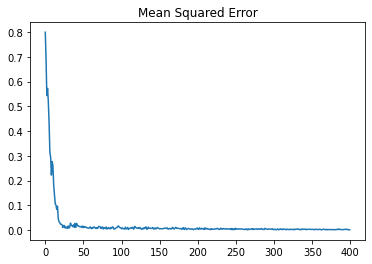

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

    
for e in range(epochs):


    out = []
    
    for b in range(-10- enc_seq_len, 10 - enc_seq_len):
        optimizer.zero_grad()
        X, Y = get_data(batch_size, enc_seq_len, output_sequence_length)
        #print(X)
        
        #Forward pass and calculate loss
        print("---------")
        net_out = t(X)
        #print(net_out.shape,Y.shape)
        loss = torch.mean((net_out - Y) ** 2)

        #backwards pass
        loss.backward()
        optimizer.step()

        #Track losses and draw rgaph
        out.append([net_out.detach().numpy(), Y])
        losses.append(loss)

        ax.clear()
        ax.plot(losses)
        ax.set_title("Mean Squared Error")
        fig.canvas.draw()
    print(f"{loss}@{e}")


In [ ]:
x = [torch.sigmoid(torch.arange(-10,-1).float()).unsqueeze(-1).numpy().tolist()]

In [ ]:
torch.tensor(x).shape

torch.Size([1, 9, 1])

after positional encoding shapetensor([[[ 0.9005,  0.6688, -0.4860,  0.5791,  0.8642,  0.2343,  0.0154,
           0.6695,  0.8624,  0.3317],
         [ 1.7419,  0.2090, -0.3282,  0.5667,  0.8893,  0.2340,  0.0195,
           0.6694,  0.8629,  0.3316],
         [ 1.8098, -0.7476, -0.1744,  0.5295,  0.9146,  0.2331,  0.0237,
           0.6692,  0.8634,  0.3313],
         [ 1.0416, -1.3219, -0.0284,  0.4687,  0.9400,  0.2314,  0.0282,
           0.6685,  0.8636,  0.3307],
         [ 0.1438, -0.9869,  0.1059,  0.3862,  0.9661,  0.2291,  0.0336,
           0.6668,  0.8630,  0.3290],
         [-0.0580, -0.0531,  0.2250,  0.2849,  0.9938,  0.2259,  0.0415,
           0.6623,  0.8602,  0.3242],
         [ 0.6222,  0.6136,  0.3252,  0.1701,  1.0263,  0.2215,  0.0561,
           0.6502,  0.8516,  0.3114],
         [ 1.5605,  0.3810,  0.4020,  0.0516,  1.0718,  0.2148,  0.0889,
           0.6173,  0.8271,  0.2765],
         [ 1.8981, -0.5902,  0.4483, -0.0485,  1.1527,  0.2030,  0.1713,
        

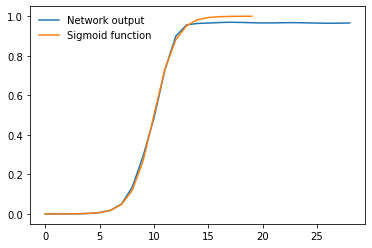

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

o = []
x = [torch.exp(torch.arange(-10,-1).float()).unsqueeze(-1).numpy().tolist()]

#Draw graph comparing to sigmoid
for i in range(-10, 10, output_sequence_length):
    o.append([torch.sigmoid(torch.tensor(i).float())])
    q = torch.tensor(x).float()
    
    if(output_sequence_length == 1):
        x[0].append([t(q).detach().squeeze().numpy()])
    else:
        for a in t(q).detach().squeeze().numpy():
            x[0].append([a])
            
ax.clear()
ax.plot(x[0], label='Network output')
ax.plot(o, label='Sigmoid function')
ax.set_title("")
ax.legend(loc='upper left', frameon=False)